## Create Initial states

In [ ]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt
import imageio


from src.models.degradation_models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP
from src.models.rul_predictor import RULPredictor

from src.helpers.visualization import create_rul_prediction_frame,plot_rul_from_dataframe
from src.helpers.seed import set_global_seed

## Task

In [36]:
data_name = "DS05"
SEED = 42


pf_dir_name = 'pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05'

set_global_seed(SEED)

## Hyper-Parameters

In [37]:
# PF-net architecture
hidden_dims = [128,128,64,32]
activation = torch.nn.LeakyReLU(0.05)

# PF parameters
n_particles = 1800
multiply_scale = 0.05

## Prediction settings
start_idx = 1
uncertainty_level = 0.95

## Plot resolution
t_grid = np.linspace(0.1, 100, 80) 
s_grid = np.linspace(0.0, 1.0, 60)

In [38]:
experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/pf_dir_name
states_dir = experiment_dir/'states'

## Load pf-models

In [39]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
dev_units = hi_df['unit'].astype(int).unique().tolist()
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle','hs']]

del hi_df

dev_units 

[1, 2, 3, 4, 5, 6]

In [40]:
pfs = {}
for name in perform_names:
	# load pf-network
	net = ParticleFilterMLP(state_dim=NModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation)
	ckpt = torch.load(pf_dir/name/'checkpoint.pt')
	net.load_state_dict(ckpt['model_state'])
	net = net.eval() 
	
	degmodels = []
	for unit in dev_units:
		best_model = NModel()
		best_model.load_state_dict(
			torch.load(states_dir/ name /f'unit_{unit}'/ "best_model.pt")
		)
		best_model
		degmodels.append(best_model)
  
	perform_pf = ParticleFilterModel(base_models = degmodels,
									net = net,
									n_particles=n_particles,
									multiply_scale=multiply_scale,
									name=f'{name}_test')
	pfs[name] = perform_pf

## Create System RUL

In [41]:
rul_pred = RULPredictor(pf_models=pfs,current_obs=False)

## Import test data


In [42]:
hi_df = pd.read_csv(experiment_dir/'hidata_test.csv')
del hi_df['hs']
test_units = hi_df['unit'].astype(int).unique().tolist()
test_units

[7, 8, 9, 10]

In [43]:
performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in test_units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in test_units}

## Prepare data

In [44]:
test_data = {}
for name, perform_units in performs.items():
    test_perform_data = {}
    for unit in test_units:
        t_data = time[unit]
        s_data = perform_units[unit]
        test_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    test_data[name]=test_perform_data

## System RUL

In [45]:
preds:list[pd.DataFrame] = []  

for test_unit in test_units:
    s_data = {name: performs[name][test_unit] for name in perform_names}
    t_data = time[test_unit]
    eol_time = time[test_unit][-1]
    frames = []
 
    def video_callback(k:int,rul_pred: RULPredictor):
        frames.append(
            create_rul_prediction_frame(
                rulpred=rul_pred,
                t_grid=t_grid,
                s_grid=s_grid,
                t_data_np=t_data,
                s_data_np=s_data,
                step=k,
                eol_time=eol_time,
                unit=test_unit,
                dist_vmax=0.3,
                dist_legend_loc="lower left",
                dist_plot_mean=False,
            )
        )
        
    rul_pred.predict(
			t_data=t_data,
			s_data=s_data,
			start_idx=start_idx,
			on_step=video_callback, # optional callback to create video frames
		)
    # Collect predictions
    df = rul_pred.history_to_dataframe()
    df["unit"] = test_unit
    df["true_rul"] = np.maximum(eol_time - df['time'], 0.0)
    preds.append(df)
    if frames:
        video_path = pf_dir/f'rul_pred_test{test_unit}.mp4'
        with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
            for frame in frames:
                writer.append_data(frame)

        print(f"🎬 Video saved to {video_path}")
    
preds_df = pd.concat(preds, ignore_index=True)
preds_df.to_csv(pf_dir / "rul_test_predictions.csv", index=False)


🎬 Video saved to experiments/DS05/pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05/rul_pred_test7.mp4
🎬 Video saved to experiments/DS05/pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05/rul_pred_test8.mp4
🎬 Video saved to experiments/DS05/pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05/rul_pred_test9.mp4
🎬 Video saved to experiments/DS05/pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05/rul_pred_test10.mp4


# Plot final RUL prediction

In [46]:
preds_df= pd.read_csv(pf_dir / "rul_test_predictions.csv")

In [47]:
pf_dir / "rul_test_predictions.csv"

PosixPath('experiments/DS05/pf_perform_normal_multnoise0.05_net128x128x64x32leaky0.05/rul_test_predictions.csv')

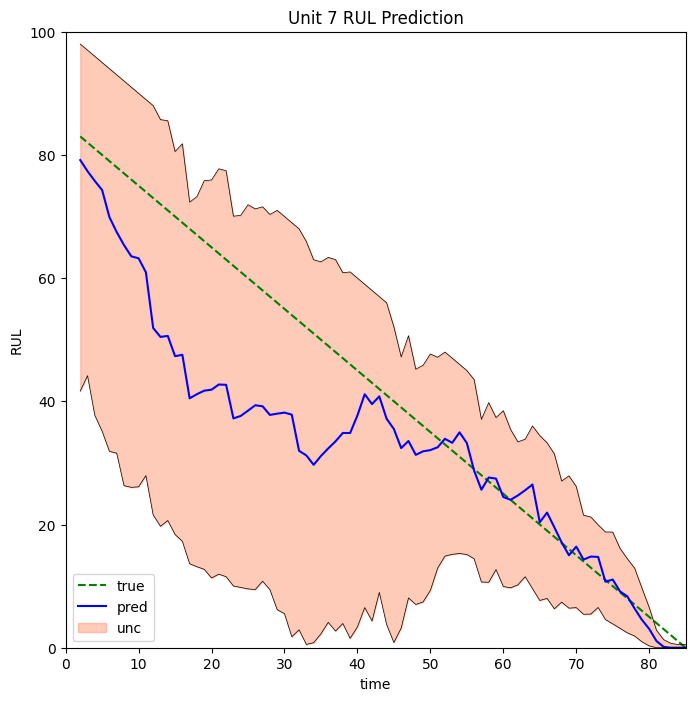

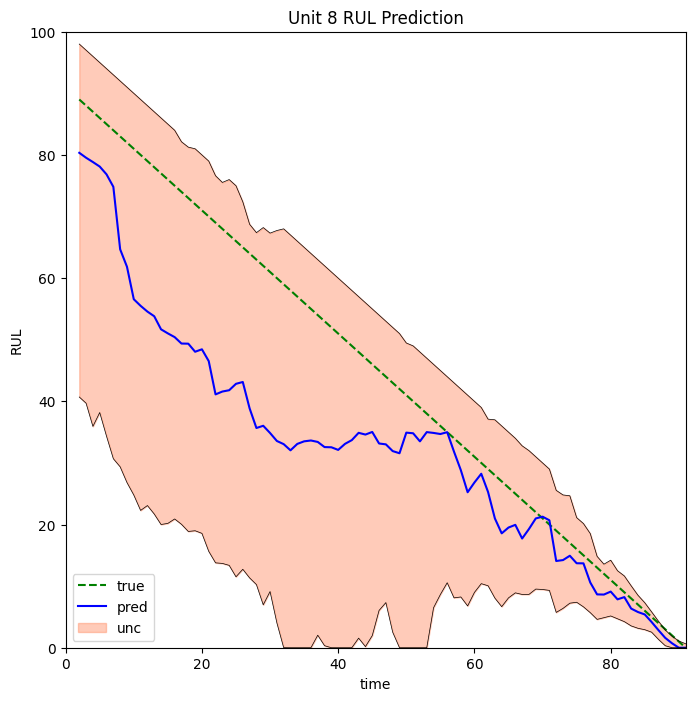

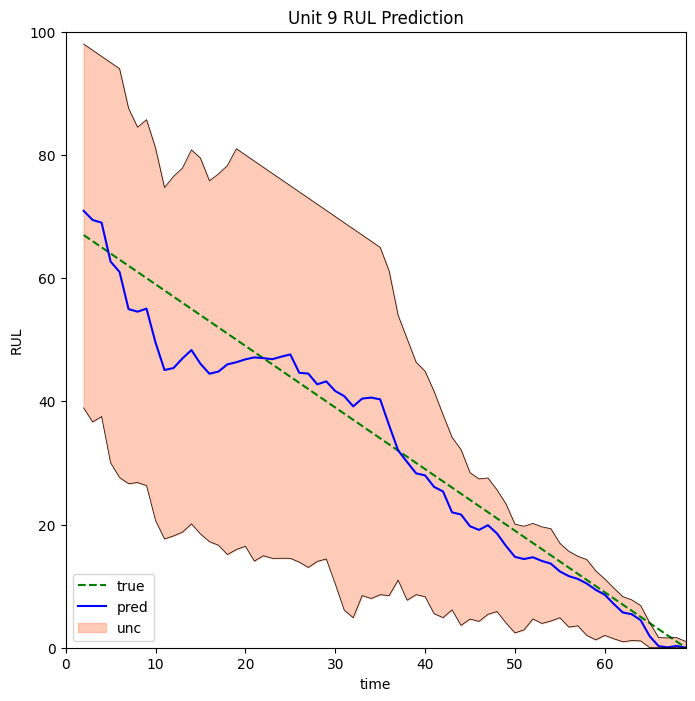

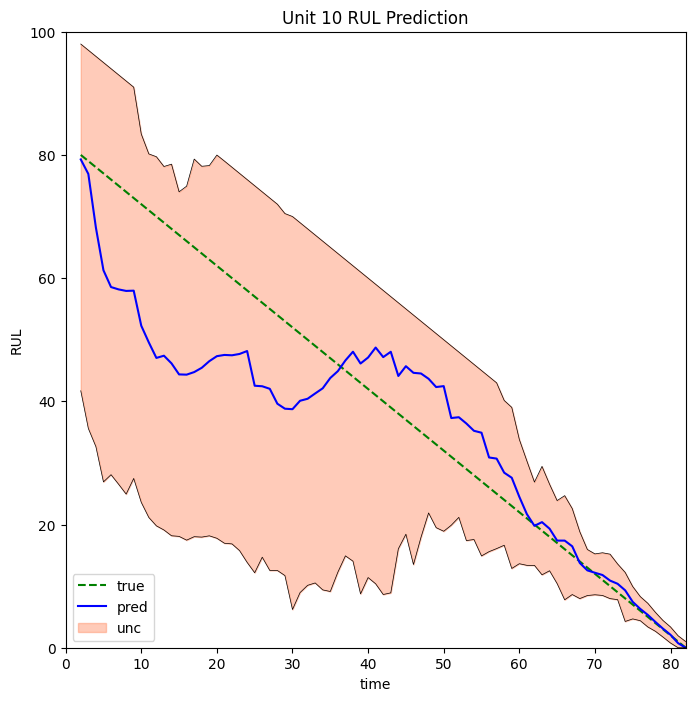

In [48]:
for unit in test_units:
	fig, ax = plt.subplots(figsize=(8, 8))
	df = preds_df[preds_df['unit']==unit]
	eol_time = df['time'].iloc[-1]
	plot_rul_from_dataframe(ax=ax, df=df,t_max=eol_time,
			title=f"Unit {unit} RUL Prediction")
	fig.savefig(pf_dir / f'rul_test_eval{unit}.png')